In [1]:
import time
import pandas as pd
import numpy as np
import sys
import re
sys.path.append('../Modules')
from ts_correlation import *
from variation_information import *
from utils_clustering import *
from preprocess_series import *
import seaborn
from scipy.cluster.hierarchy import fcluster, ward, dendrogram
from tslearn.clustering import silhouette_score
from read_prepare_input_clustering import *
from utils_clustering_time_windows import *
from tsmoothie.smoother import *
from tslearn.preprocessing import TimeSeriesScalerMinMax, TimeSeriesScalerMeanVariance
from sklearn.neighbors import NearestCentroid
from sklearn_extra.cluster import KMedoids

In [11]:
## PARAMETERS

# Number of days in each time window
window_shape = 90

# Specify whether you want to use data transformed via autoencoder
use_autoencoder = True

# Distance metric for clustering algorithm
distance_metric = 'euclidean'

# Specify whether you want to use first-order differences or work with raw time series
use_differences = False

# Specify whether you want to subtract series barycenter from each series
# If so, specify metric for barycenter computation
subtract_sector_barycenter = False
sector_barycenter_metric = 'euclidean'

# Class used to scale time series data
# - TimeSeriesScalerMinMax(): scaling each series between min and max value
# - TimeSeriesScalerMeanVariance(): scaling each series to have mean mu and unitary standard deviation
# - None for no scaling
time_series_scaler = TimeSeriesScalerMinMax()

# Max number of clusters in the experiments
max_num_clusters = 30

# CLustering algorithm
# - kMeans
# - hierarchical
clustering_algorithm = 'kMeans'

# Linkage hierarchical clustering
linkage_hierarchical_clustering = 'ward'

# Remove correlated risk factors
rem_corr_rf = False
corr_threshold = 0.7

# Metric to link issuer curves and risk factors to evaluate risk factor effect on curves in the same cluster
#  - 'corr' -> linear correlation
#  - 'corr_based_dist' -> correlation-based distance
#  - 'varInfo' -> variation of information
link_metrics = 'corr_based_dist'

# Number of top risk factors to include
num_top_rf = 5

In [3]:
# Read input data

df_all, df_all_lookup, obs_universe_fx, obs_universe_local, risk_factors_to_include = import_data_clustering_issuer_rf()

risk_factors_to_include = list(pd.read_csv('../Data/RiskFactor_Local_FX_20220606.csv', sep=';').iloc[:, 1])

In [4]:
# Remove series having more than 90% NA values

df_all_lookup_complete = remove_series_mostly_na(df_all_lookup, 0.9)
obs_universe_local = remove_series_mostly_na(obs_universe_local, 0.9)
obs_universe_fx = remove_series_mostly_na(obs_universe_fx, 0.9)

print('Min date in observation universe fx: ' + str(min(obs_universe_fx.index)))
print('Max date in observation universe fx: ' + str(max(obs_universe_fx.index)))
print('\n')

print('Min date in observation universe local: ' + str(min(obs_universe_local.index)))
print('Max date in observation universe local: ' + str(max(obs_universe_local.index)))
print('\n')

print('Min date in curves df: ' + str(min(df_all_lookup_complete.index)))
print('Max date in curves df: ' + str(max(df_all_lookup_complete.index)))

min_dates = [min(obs_universe_fx.index), min(obs_universe_local.index), min(df_all_lookup_complete.index)]
max_dates = [max(obs_universe_fx.index), max(obs_universe_local.index), max(df_all_lookup_complete.index)]

# Min and max dates for which we have all data available
lb_dates = max(min_dates)
ub_dates = min(max_dates)

df_all_lookup_filtered = df_all_lookup_complete[(df_all_lookup_complete.index >= lb_dates) & 
                                                (df_all_lookup_complete.index <= ub_dates)]
df_universe_fx_filtered = obs_universe_fx[(obs_universe_fx.index >= lb_dates) &
                                          (obs_universe_fx.index <= ub_dates)]
df_universe_local_filtered = obs_universe_local[(obs_universe_local.index >= lb_dates) &
                                                (obs_universe_local.index <= ub_dates)]

df_risk_factors = pd.concat([df_universe_fx_filtered, df_universe_local_filtered], axis=1)
risk_factors_to_include_available = list(set(df_risk_factors.columns).intersection(set(risk_factors_to_include)))
df_risk_factors = df_risk_factors[risk_factors_to_include_available]

# Merge df with curves and df with risk factors
df_complete = df_all_lookup_filtered.merge(df_risk_factors, left_index=True, right_index=True)

Maximum Timestamp of available data point 2015-05-21 00:00:00
Minimum Timestamp of not null data point cross time series 2021-12-06 00:00:00
Maximum Timestamp of available data point 2015-05-15 00:00:00
Minimum Timestamp of not null data point cross time series 2022-05-13 00:00:00
Maximum Timestamp of available data point 2015-05-15 00:00:00
Minimum Timestamp of not null data point cross time series 2022-05-13 00:00:00
Min date in observation universe fx: 2015-05-15 00:00:00
Max date in observation universe fx: 2022-05-13 00:00:00


Min date in observation universe local: 2015-05-15 00:00:00
Max date in observation universe local: 2022-05-13 00:00:00


Min date in curves df: 2015-05-21 00:00:00
Max date in curves df: 2021-12-06 00:00:00


In [5]:
# #### READ TIME SERIES FITTED BY GARCH MODEL

# temp = pd.read_csv('cond_vola_issuer.csv', sep=';')
# temp = temp.rename(columns={'Date[Date]': 'Date'}).set_index('Date', drop=True)
# df_complete = temp.copy()

In [6]:
# Check correlation between risk factors
if rem_corr_rf:
    rf_to_remove = remove_correlated_risk_factors(df_complete, risk_factors_to_include, corr_threshold,
                                                  rf_to_keep=['VIX (16)[CBOE - Market Volatility Index]'])
    risk_factors_to_include_available = list(set(risk_factors_to_include_available).difference(set(rf_to_remove)))
    print(str(len(set(rf_to_remove))) + ' risk factors removed due to high correlation: ' + str(set(rf_to_remove)))

In [7]:
# Preprocess data as specified in input parameters

# Df with all sectors
df_all_sectors = df_all[['CurveID','MS_Sector']].drop_duplicates()
df_all_sectors.loc[df_all_sectors['MS_Sector']=='Financial','MS_Sector'] = 'Financials'

df_all_lookup_filtered = preprocess_data(df_all_lookup_filtered,
                                        df_all_sectors,
                                        dict({'use_differences': use_differences,
                                             'scaling_strategy': None,
                                             'subtract_sector_barycenter': subtract_sector_barycenter,
                                             'sector_barycenter_metric': sector_barycenter_metric,
                                             'dim_reduction': False,
                                             'dim_reduction_alg': None,
                                             'dim_reduction_num_components': None,
                                             'dim_red_rnd_state': None}))

In [8]:
df_transposed = df_all_lookup_filtered.T
df_transposed.shape

(223, 1708)

In [12]:
if use_autoencoder:

    df_decoded = pd.read_csv('decoded_series_issuer.csv', sep=';').\
        set_index('curveId', drop=True)
    df_transposed_bkp = df_transposed.copy()
    df_transposed = df_decoded.copy()
    
    time_series_scaler = None

In [16]:
# ###### FOR SERIES AFTER GARCH
# df_transposed = df_complete.loc[:, df_all_lookup_filtered.columns].T
# df_transposed.shape

In [17]:
# Generate time windows for all series in the dataframe
# Time windows are disjoint, there is no overlapping between two different windows generated from the same series
window_values = split_series_in_time_windows(df_transposed, window_shape, time_series_scaler=time_series_scaler)

# Compute time windows start and end dates
time_windows, string_time_windows = get_time_windows_bounds(df_transposed, window_shape)

Elapsed time: 317.0519063472748


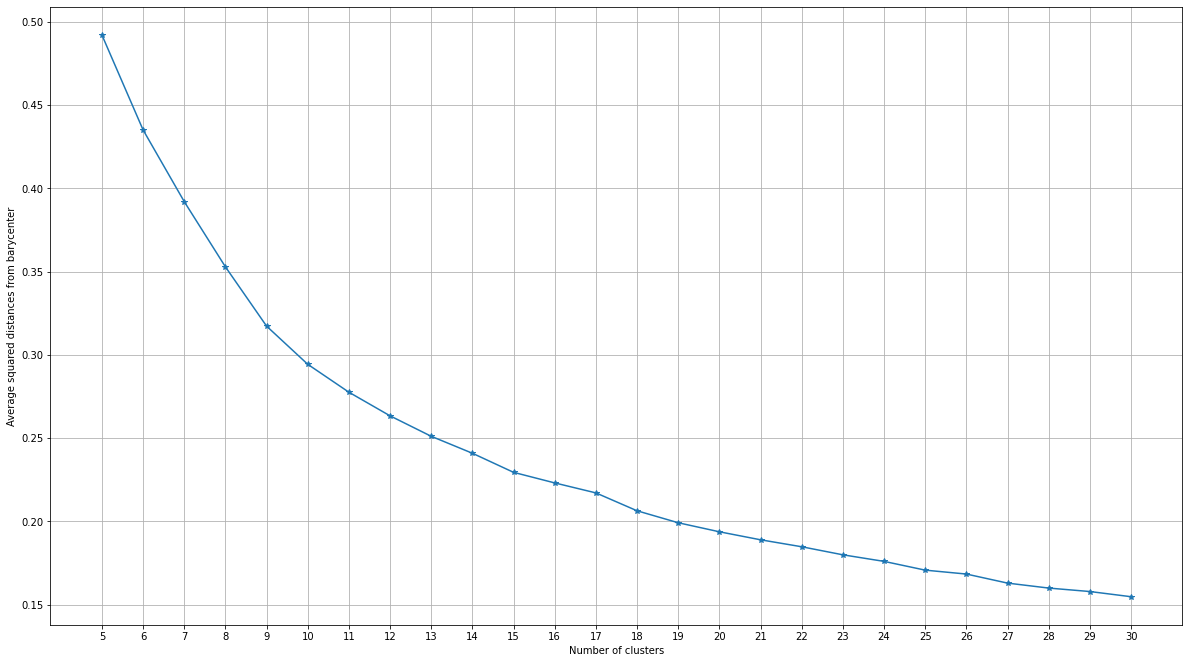

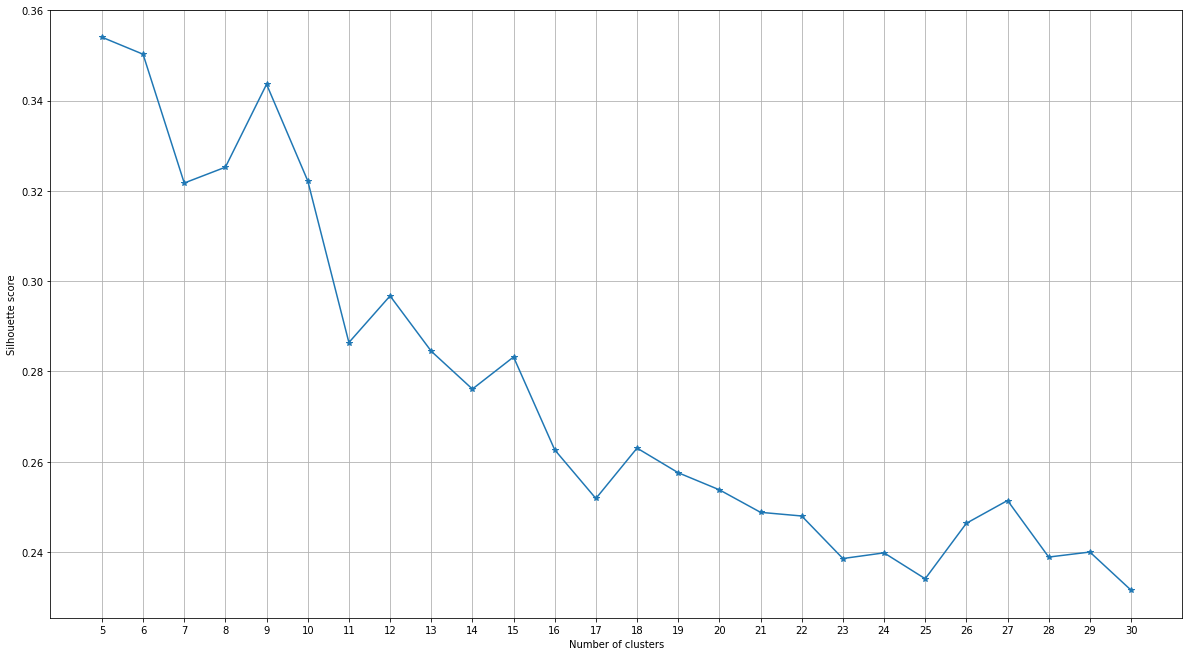

In [51]:
# K-Means clustering

if clustering_algorithm == 'kMeans':

    start = time.time()
    clustering_results, silhouette_scores, inertia_scores = \
        try_k_means_varying_k(window_values, use_ts_kmeans=True, metric_distance=distance_metric,
                              min_num_clusters = 5, max_num_clusters = max_num_clusters, n_init = 2)
    print('Elapsed time: ' + str(time.time() - start))
    
    # Elbow plot of inertia
    plot_kpi_by_num_clusters(inertia_scores, 'Average squared distances from barycenter')
    
    # Plot of silhouette score
    plot_kpi_by_num_clusters(silhouette_scores, 'Silhouette score')

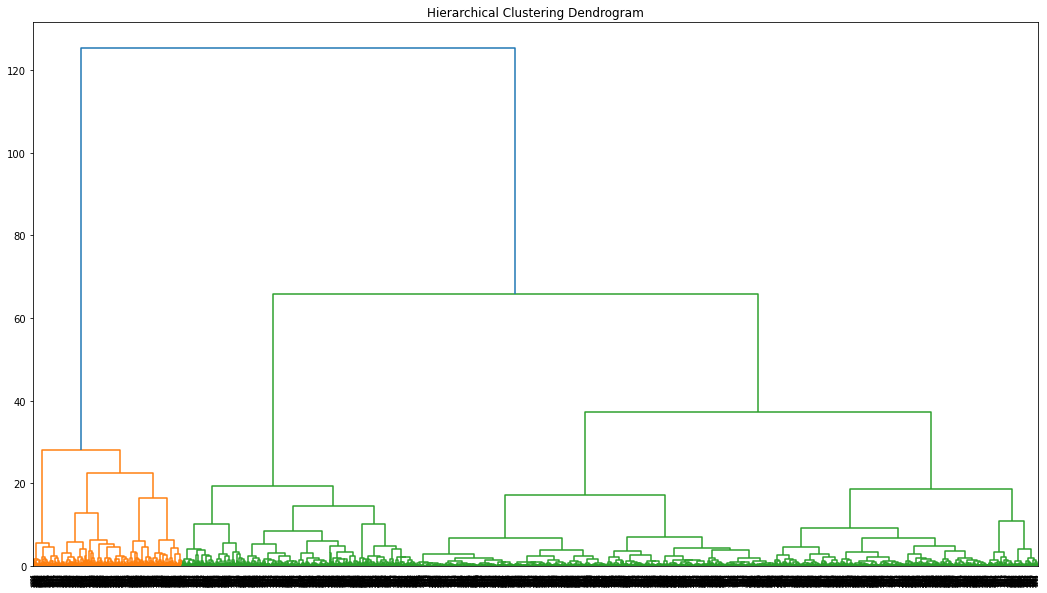

Elapsed time: 153.306569814682


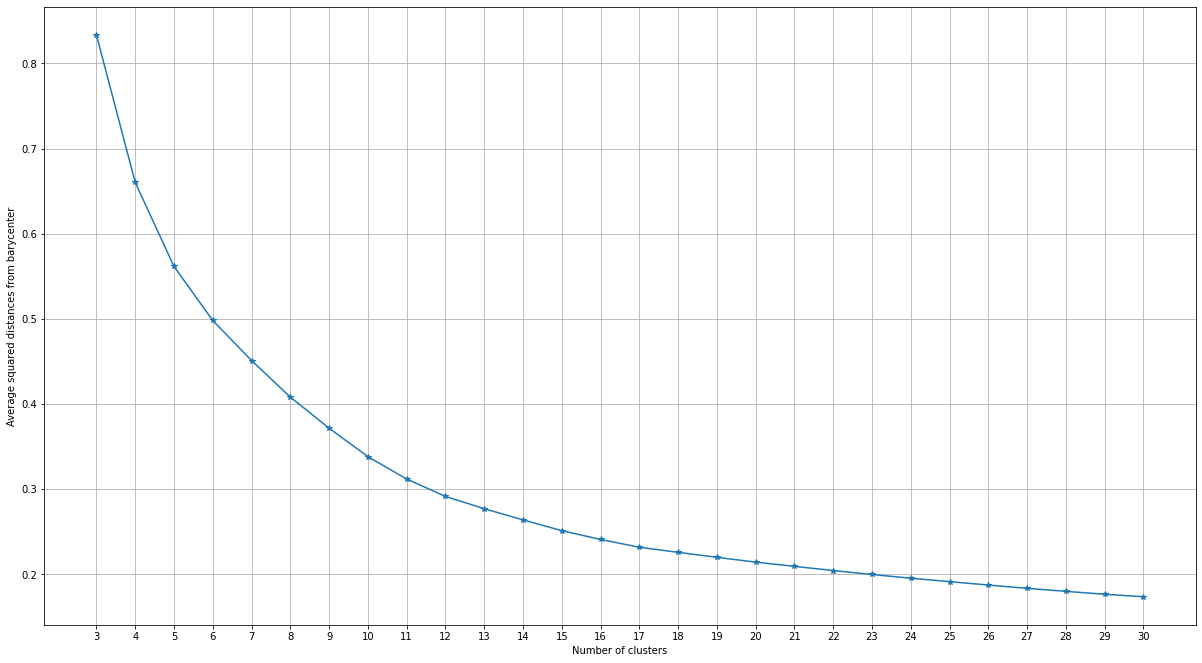

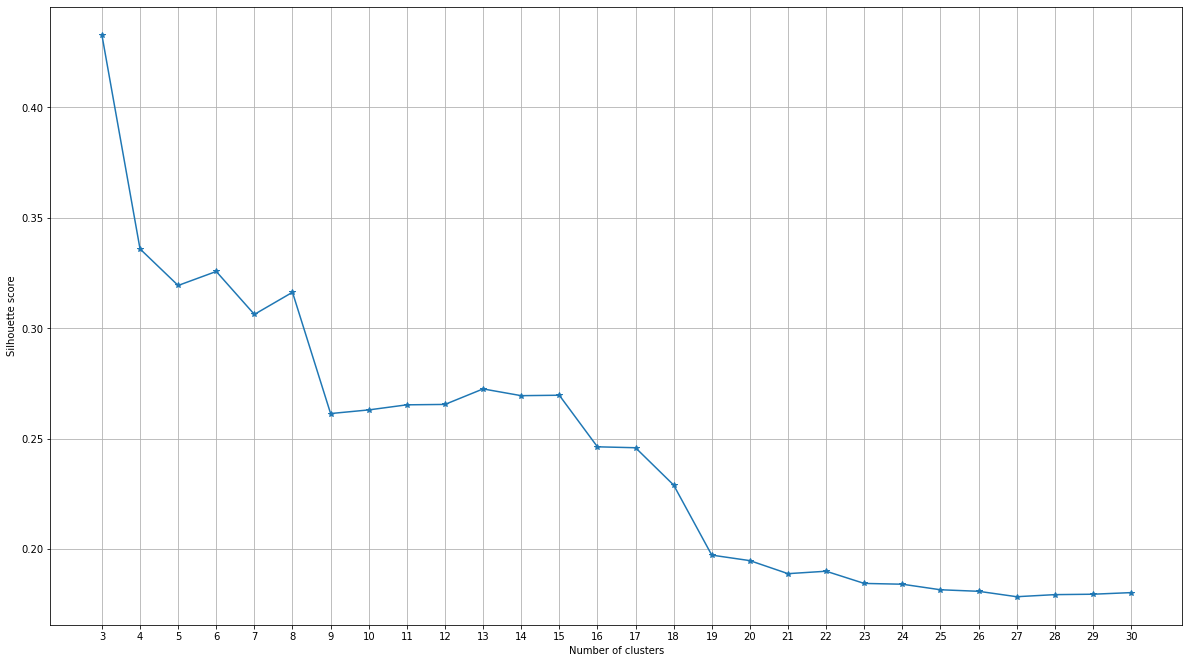

In [44]:
# Hierarchical clustering

if clustering_algorithm == 'hierarchical':

    start = time.time()
    
    hier_clust_fit, linkage = \
        hierarchical_clustering_and_dendrogram(window_values.reshape(window_values.shape[0], window_values.shape[1]),
                                                                    linkage_hierarchical_clustering)

    # Find clustering results for different values of number of clusters from dendrogram
    clustering_results = {}
    for i in range(3, max_num_clusters+1):
        clusters = fcluster(linkage, t=i, criterion='maxclust')
        clustering_results[i] = clusters

    # Silhouette scores and inertia for the different numbers of clusters
    silhouette_scores = {}
    inertia_scores = {}
    for i in clustering_results:
        sil_score = silhouette_score(window_values.reshape(window_values.shape[0], window_values.shape[1]),
                                     clustering_results[i], metric='euclidean')
        silhouette_scores[i] = sil_score
        inertia_scores[i] = compute_inertia(pd.DataFrame(window_values.reshape(window_values.shape[0], window_values.shape[1])),
                                                         clustering_results[i])
        
    print('Elapsed time: ' + str(time.time() - start))

    # Plot of insertia
    plot_kpi_by_num_clusters(inertia_scores, 'Average squared distances from barycenter')
    
    # Plot of silhouette score
    plot_kpi_by_num_clusters(silhouette_scores, 'Silhouette score')

In [52]:
# Build df with curve id as index and a column per each time window, specifying cluster where the curve belongs
# to in that time windows

# Number of clusters for the result to be saved
num_clusters = 6

clusters_per_curve = {}
num_windows = int(np.floor(df_transposed.shape[1]/window_shape))
for i in range(len(df_transposed.index)):
    labels_curr_curve = clustering_results[num_clusters][i*num_windows:((i+1)*num_windows)]
    clusters_per_curve[df_transposed.index[i]] = labels_curr_curve

df_clustering_results = pd.DataFrame(clusters_per_curve.items(), columns=['curveId', 'list_clusters'])
df_clustering_results = df_clustering_results.set_index('curveId', drop=True)
df_clustering_results =  pd.concat([df_clustering_results[c].apply(pd.Series).add_prefix(c + "_") for c in df_clustering_results], axis=1)

In [53]:
# Write output .csv with curves on the rows and time windows on the columns

idx_file_name= '1'
    
df_clustering_results.columns = list(string_time_windows.values())

df_clustering_results.to_csv('../Output/4.3_Clustering_Results/res_tw_autoencoder_' + idx_file_name + '.csv', sep=';')

In [54]:
df_clustering_results

2015/05/21-2015/09/23  2015/09/24-2016/01/27  \
curveId                                                                    
AALLN-19392-EUR-SNR-BND                         2                      4   
ABT-2254033-USD-SNR-BND                         1                      1   
ACAFP-18185-EUR-SNR-BND                         5                      5   
ACEIM-24415-EUR-SNR-BND                         4                      4   
ACESM-77-EUR-SNR-BND                            1                      5   
...                                           ...                    ...   
WPC-45167-USD-SNR-BND                           5                      4   
WPPLN-20216-EUR-SNR-BND                         1                      1   
ZFFNGR-3673421-EUR-SNR-BND                      1                      1   
ZKB-21978-CHF-SNR-BND                           4                      4   
ZURNVX-22877-EUR-SNR-BND                        1                      5   

                            2016/01/28-2016/06/01  2016/06/02-2016/10/05  \
curveId                                                                    
AALLN-19392-EUR-SNR-BND                         3                      1   
ABT-2254033-USD-SNR-BND                         1                      1   
ACAFP-18185-EUR-SNR-BND                         1                      2   
ACEIM-24415-EUR-SNR-BND                         5                      1   
ACESM-77-EUR-SNR-BND                            1                      2   
...                                           ...                    ...   
WPC-45167-USD-SNR-BND                           4                      4   
WPPLN-20216-EUR-SNR-BND                         1                      2   
ZFFNGR-3673421-EUR-SNR-BND                      1                      2   
ZKB-21978-CHF-SNR-BND                           0                      0   
ZURNVX-22877-EUR-SNR-BND                        5                      2   

                            2016/10/06-2017/02/08  2017/02/09-2017/06/14  \
curveId                                                                    
AALLN-19392-EUR-SNR-BND                         2                      2   
ABT-2254033-USD-SNR-BND                         1                      2   
ACAFP-18185-EUR-SNR-BND                         2                      2   
ACEIM-24415-EUR-SNR-BND                         1                      1   
ACESM-77-EUR-SNR-BND                            2                      2   
...                                           ...                    ...   
WPC-45167-USD-SNR-BND                           4                      5   
WPPLN-20216-EUR-SNR-BND                         2                      2   
ZFFNGR-3673421-EUR-SNR-BND                      2                      2   
ZKB-21978-CHF-SNR-BND                           3                      5   
ZURNVX-22877-EUR-SNR-BND                        2                      2   

                            2017/06/15-2017/10/18  2017/10/19-2018/02/21  \
curveId                                                                    
AALLN-19392-EUR-SNR-BND                         2                      2   
ABT-2254033-USD-SNR-BND                         2                      2   
ACAFP-18185-EUR-SNR-BND                         2                      2   
ACEIM-24415-EUR-SNR-BND                         2                      2   
ACESM-77-EUR-SNR-BND                            2                      2   
...                                           ...                    ...   
WPC-45167-USD-SNR-BND                           5                      1   
WPPLN-20216-EUR-SNR-BND                         2                      2   
ZFFNGR-3673421-EUR-SNR-BND                      2                      2   
ZKB-21978-CHF-SNR-BND                           5                      2   
ZURNVX-22877-EUR-SNR-BND                        2                      2   

                            2018/02/22-2018/06/27  2018/06/28-2018/10/31

## Plot clusters centres and samples

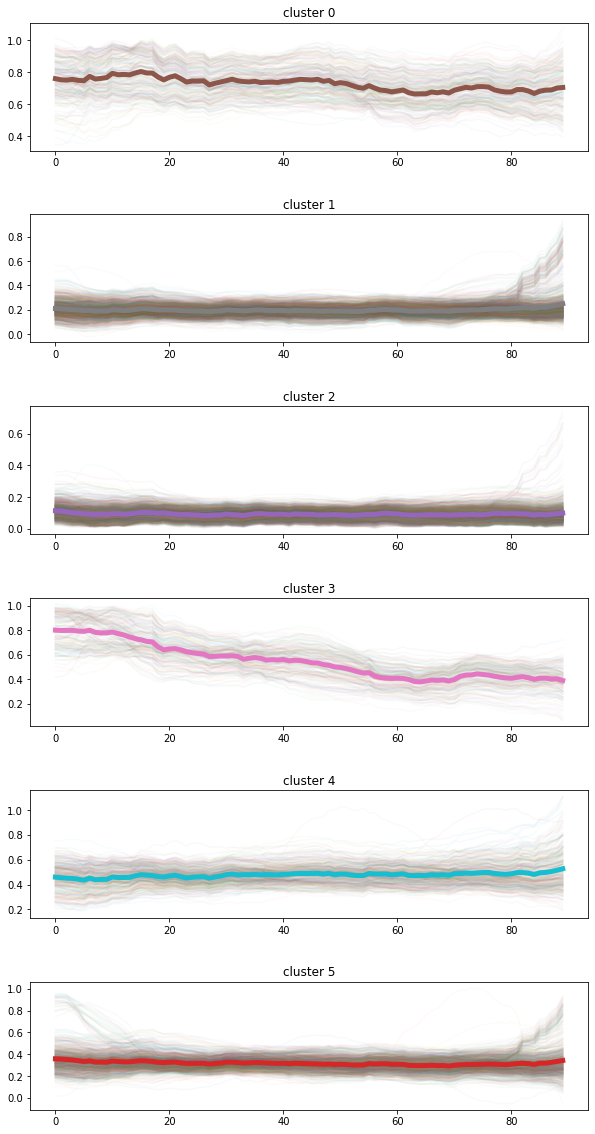

In [55]:
### PLOT CLUSTER CENTERS WITH SAMPLES ###
# Preprocessed series is shown, so after rescaling and other operations done on raw series

if clustering_algorithm == 'kMeans':

    km_fit = TimeSeriesKMeans(n_clusters=num_clusters, metric=distance_metric, max_iter=50, random_state=0, n_init=2,
                                          max_iter_barycenter=10).fit(window_values)
    clust_labels = km_fit.labels_
    centroids = km_fit.cluster_centers_
    
else:
    
    clf = NearestCentroid()
    clf.fit(np.squeeze(window_values), clustering_results[num_clusters])
    clust_labels = clustering_results[num_clusters]
    centroids = clf.centroids_
    

fig = plt.figure()

for c in range(len(list(set(clust_labels)))):
    
    cluster_label = list(set(clust_labels))[c]
   
    ax = fig.add_subplot(len(set(clust_labels)), 1, c+1)
    # Plot preprocessed series and barycenters
    ax.plot(np.squeeze(window_values[clust_labels == cluster_label]).T, alpha=0.03)
    ax.plot(np.squeeze(centroids)[c], linewidth=5)
        
    plt.title(f"cluster {cluster_label}")
    
    
fig.subplots_adjust(hspace=0.5)
fig.set_size_inches(10, 20)
fig.savefig('../Output/4.3_Clustering_Results/res_tw_autoencoder_' + idx_file_name + '.png', facecolor='white')

In [86]:
# Compute distance matrix between clusters' centroids

from scipy.spatial.distance import cdist 

centroids_distances = pd.DataFrame(cdist(centroids.reshape(centroids.shape[0], centroids.shape[1]),
                                         centroids.reshape(centroids.shape[0], centroids.shape[1]),
                                         metric='euclidean'))

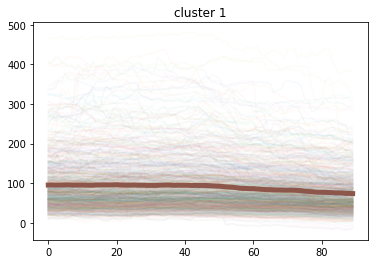

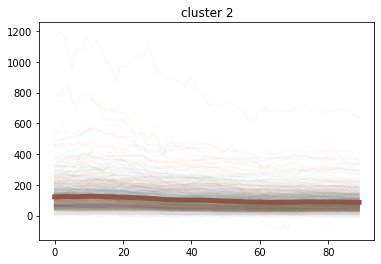

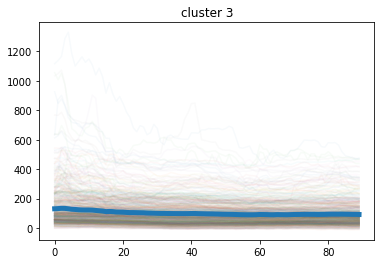

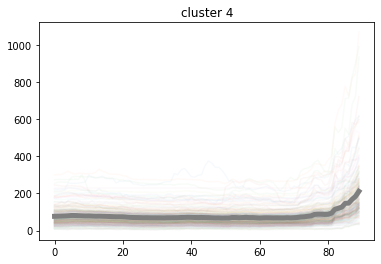

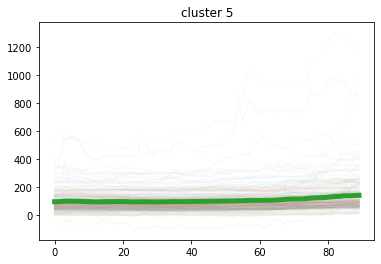

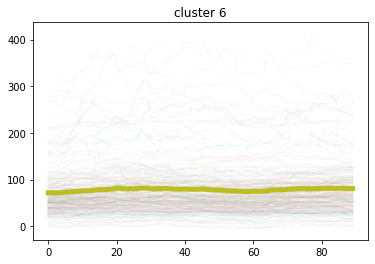

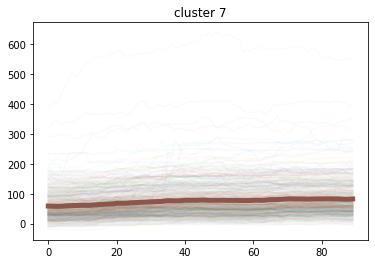

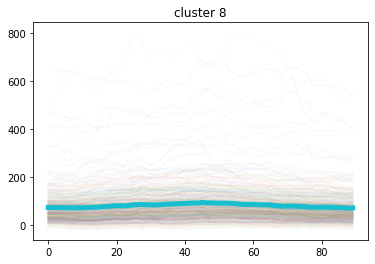

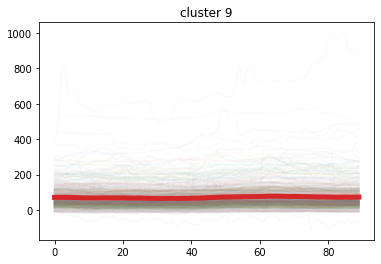

In [27]:
### PLOT CLUSTER CENTERS WITH SAMPLES ###
# Original series are shown, with the highlighted line being the average of all series in the cluster

for c in range(len(list(set(clust_labels)))):
    
    cluster_label = list(set(clust_labels))[c]
    
    # Plot original series and average in each cluster
    plt.plot(np.squeeze(smooth_data_df.loc[clust_labels == cluster_label].values).T, alpha=0.03)
    plt.plot(smooth_data_df.loc[clust_labels == cluster_label].apply(np.average), linewidth=5)

    plt.title(f"cluster {cluster_label}")
    
    plt.show()

## Evaluate links between curves in each cluster and risk factors

In [57]:
# MOST RELEVANT RISK FACTORS IN EACH CLUSTER-TIME WINDOW

res_top_tw = find_top_k_rf_correlation_by_time_window(df_clustering_results,
                                                     df_complete,
                                                     time_windows,
                                                     num_top_rf,
                                                     risk_factors_to_include_available,
                                                     link_metrics)

In [83]:
#### BUILD CSV WITH TOP K RF PER EACH TIME_WINDOW - CLUSTER

# Dictionary with top rf per tw-cl ordered by value of link metric
res_top_rf_ordered = {}
for tw in res_top_tw:
    res_top_rf_ordered[tw] = {}
    for cl in res_top_tw[tw]:
        res_top_rf_ordered[tw][cl] = list(pd.DataFrame(res_top_tw[tw][cl]).\
                                              sort_values(by='avg_corr', ascending=(link_metrics!='corr'))['factors'])

res_final_df = pd.DataFrame()

for tw in res_top_rf_ordered:
    
    temp = pd.DataFrame(res_top_rf_ordered[tw].items(), columns=['cluster', 'riskFactor']).\
        sort_values(by='cluster')
    x = pd.concat(
        [temp[c].apply(pd.Series).add_prefix(c + "_") for c in ['riskFactor']], axis=1
    ).rename(
        columns=lambda x: "{}_{}".format(x.split("_")[0], int(x.split("_")[1]) + 1)
    )
    x = x.set_index(temp['cluster']).reset_index()
    x['time_window'] = string_time_windows[tw]
    res_final_df = pd.concat([res_final_df, x], ignore_index=True)
    
res_final_df = res_final_df[['cluster', res_final_df.columns[-1], *[c for c in res_final_df.columns if re.match('riskFactor', c)]]]

res_final_df.to_csv('../Output/4.3_Clustering_Results/top_rf_tw_autoencoder_' + idx_file_name + '.csv', sep=';', index=False)

In [85]:
#### BUILD CSV WITH TOP K RF PER EACH CLUSTER
#### Risk factors are sorted based on number of time windows where they appear as most relevant for that cluster

# Count how many times each risk factor appears among the top k for a cluster

top_rf_per_cluster = {}

for tw in res_top_tw:
    for cl in res_top_tw[tw]:
        if cl not in top_rf_per_cluster:
            top_rf_per_cluster[cl] = {}
        for rf in res_top_tw[tw][cl]['factors']:
            if rf in top_rf_per_cluster[cl]:
                top_rf_per_cluster[cl][rf] += 1
            else:
                top_rf_per_cluster[cl][rf] = 1
                
# Starting from previous result, take the top k factors for each cluster.
# Ranking is done based on the number of times that a risk factor appears among the top k for that cluster
final_top_rf_per_cl = {}

for cl in top_rf_per_cluster:
    res_curr_cl = pd.DataFrame(top_rf_per_cluster[cl].items(), columns=['rf', 'count'])
    top_rf = list(res_curr_cl.sort_values(by='count', ascending=False)['rf'].head(num_top_rf))
    final_top_rf_per_cl[cl] = top_rf
    
# pd.DataFrame(final_top_rf_per_cl.items(), columns=['cl', 'rf']).explode('rf').\
#     groupby('rf').count()

temp = pd.DataFrame(final_top_rf_per_cl.items(), columns=['cluster', 'riskFactors']).\
    sort_values(by='cluster')
res_df = pd.concat(
        [temp[c].apply(pd.Series).add_prefix(c + "_") for c in ['riskFactors']], axis=1
    ).rename(
        columns=lambda x: "{}_{}".format(x.split("_")[0], int(x.split("_")[1]) + 1)
    )
res_df = res_df.set_index(temp['cluster']).reset_index().\
    to_csv('../Output/4.3_Clustering_Results/top_rf_per_cl_autoencoder_' + idx_file_name + '.csv', sep=';', index=False)

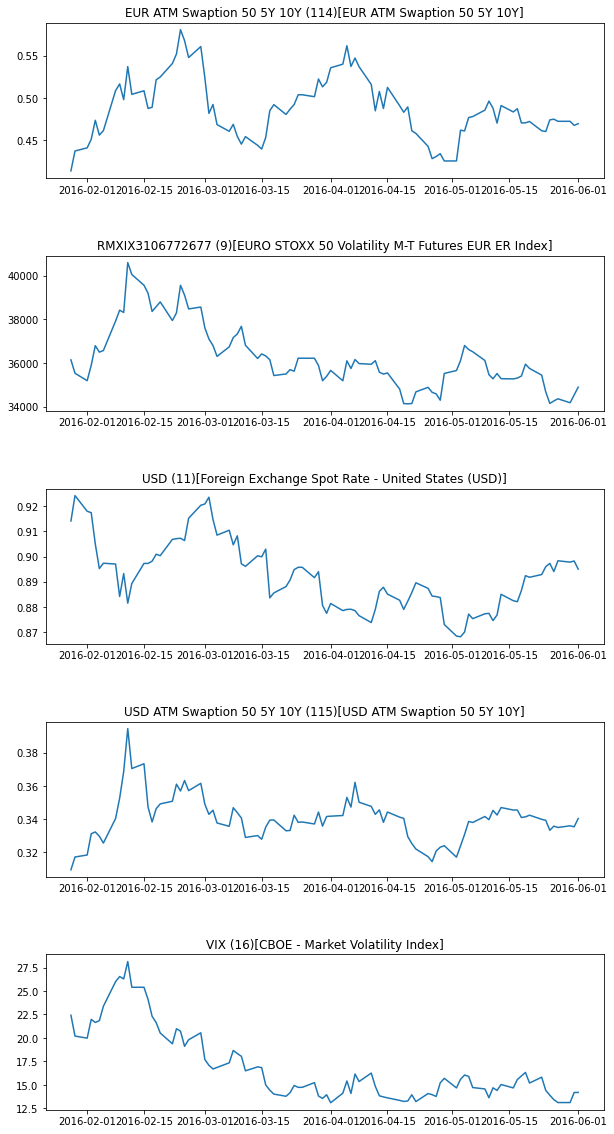

In [45]:
# Examine most relevant risk factor patterns

tw = 2
cl = 2

rf_curr_cl = res_top_tw[tw][cl]['factors']
df_rf_curr_cl_tw = df_complete.loc[(df_complete.index >= time_windows[tw][0]) & (df_complete.index <= time_windows[tw][1]),
                                   rf_curr_cl]

fig = plt.figure()

for c in range(df_rf_curr_cl_tw.shape[1]):
    
    ax = fig.add_subplot(num_top_rf, 1, c+1)

    # Plot risk factors' series
    ax.plot(df_rf_curr_cl_tw.loc[:, df_rf_curr_cl_tw.columns[c]])
        
    plt.title(f"{df_rf_curr_cl_tw.columns[c]}")
    
    
fig.subplots_adjust(hspace=0.5)
fig.set_size_inches(10, 20)

In [44]:
# Count how many times each risk factor appears for a pair cluster-window
count_rf = {}
for i in res_top_tw:
    for j in res_top_tw[i]:
        for k in res_top_tw[i][j]['factors']:
            if k in count_rf:
                count_rf[k] += 1
            else:
                count_rf[k] = 1
                
pd.DataFrame(count_rf.items(), columns=['rf', 'count']).\
    sort_values(by='count', ascending=False)

rf  count
3   USD ATM Swaption 50 5Y 10Y (115)[USD ATM Swapt...     62
2   RMXIX3106772677 (9)[EURO STOXX 50 Volatility M...     60
1   JPY (8)[Foreign Exchange Spot Rate - Japan (JPY)]     58
0   EUR ATM Swaption 50 5Y 10Y (114)[EUR ATM Swapt...     50
4            VIX (16)[CBOE - Market Volatility Index]     45
9   UTS000000052590996|30D (3)[EUX -- Bloomberg Pr...     42
6   EUR 6M Swap (SP)|60M (52)[EUR 6M Interest Rate...     36
5   USD (11)[Foreign Exchange Spot Rate - United S...     35
10  UTS000000055702777|1M (5)[EUX -- Eurex Bloombe...     34
13  USD Govt - On the Run (SP)|60M (109)[United St...     34
8   EU HICPxT A-3L BEI Govt|60M (1)[EU HICP ex Tob...     31
14  CNY 3M Swap (SP) 1Y LPR|60M (43)[CNY 3M Intere...     30
16  RMXIX3108258266 (12)[MSCI WORLD CORE INFRASTRU...     30
11  UTS000000055702779|1M (6)[EUX -- Eurex Bloombe...     29
15  CNY Govt (NS)|60M (46)[China Government Debt B...     27
7   UTS000000055702776|1M (4)[EUX -- Eurex Bloombe...     25
12  US CPI A-3L BEI Govt (SP)|60M (2)[U.S. CPI Sea...     23
17  RMXIX3107873667 (10)[WORLD AGRICULTURE & FOOD ...     19
18               Nikkei (7)[Japan - Nikkei 225 Index]     15

## Assign each curve to one cluster, irrespective of time windows

1) A distance between curves is computed based on results of clustering with time windows:
   * d_tw(c_i, c_j) = d(centroid_cl_i, centroid_cl_j), where centroid_cl_i is the centroid of the cluster where curve c_i belongs in time window tw
   * d(c_i, c_j) = sum_{tw} (d_tw(c_i, c_j))
   
2) Once this distance is computed, it is used as distance matrix for hierarchical/K-Medoids clustering to obtain a clustering of the issuer curves

**NOTE**: HIERARCHICAL CLUSTERING WAS NOT USED BECAUSE IT LED TO NON-HOMOGENEOUS CLUSTERS: THERE WERE CLUSTERS WITH LOTS OF CURVES AND MANY OTHERS WITH A FEW CURVES

In [87]:
# List of clusters 
clusters_list = []
for col in df_clustering_results:
    clusters_list = [*clusters_list, *list(df_clustering_results[col].unique())]
    
clusters_list = list(set(clusters_list))

# Rearrange df with distances between cluster centroids
n_clusters = len(centroids_distances)
centroids_distances.index = clusters_list
centroids_distances.columns = clusters_list
centroids_distances

0         1         2         3         4         5
0  0.000000  5.035563  6.038823  1.998816  2.418883  3.900592
1  5.035563  0.000000  1.012921  3.549356  2.647295  1.137856
2  6.038823  1.012921  0.000000  4.487464  3.656401  2.140806
3  1.998816  3.549356  4.487464  0.000000  1.566338  2.471402
4  2.418883  2.647295  3.656401  1.566338  0.000000  1.533227
5  3.900592  1.137856  2.140806  2.471402  1.533227  0.000000

In [88]:
# Use the distance between centroids as distance between curves not belonging to the same cluster

temp = df_clustering_results.reset_index(drop=True)

complete_mat = np.zeros((len(df_clustering_results), len(df_clustering_results)))

for tw in df_clustering_results.columns:
    mat = np.zeros((len(df_clustering_results), len(df_clustering_results)))
    for i in range(len(temp)):
        for j in range(i+1, len(temp)):
            temp_curr_tw = temp.loc[:, tw].values
            mat[i][j] = centroids_distances.loc[temp_curr_tw[i]][temp_curr_tw[j]]
            mat[j][i] = centroids_distances.loc[temp_curr_tw[i]][temp_curr_tw[j]]
            
    complete_mat = complete_mat + mat
    
df_distance_curves = pd.DataFrame(complete_mat, index=df_clustering_results.index, columns=df_clustering_results.index)
df_distance_curves

curveId                     AALLN-19392-EUR-SNR-BND  ABT-2254033-USD-SNR-BND  \
curveId                                                                        
AALLN-19392-EUR-SNR-BND                    0.000000                14.414984   
ABT-2254033-USD-SNR-BND                   14.414984                 0.000000   
ACAFP-18185-EUR-SNR-BND                   23.082913                13.090381   
ACEIM-24415-EUR-SNR-BND                   38.077953                31.331222   
ACESM-77-EUR-SNR-BND                      27.277752                17.173021   
...                                             ...                      ...   
WPC-45167-USD-SNR-BND                     29.562529                25.098781   
WPPLN-20216-EUR-SNR-BND                   27.263934                14.891154   
ZFFNGR-3673421-EUR-SNR-BND                17.889527                11.702655   
ZKB-21978-CHF-SNR-BND                     42.126570                39.703395   
ZURNVX-22877-EUR-SNR-BND                  15.697504                 9.936654   

curveId                     ACAFP-18185-EUR-SNR-BND  ACEIM-24415-EUR-SNR-BND  \
curveId                                                                        
AALLN-19392-EUR-SNR-BND                   23.082913                38.077953   
ABT-2254033-USD-SNR-BND                   13.090381                31.331222   
ACAFP-18185-EUR-SNR-BND                    0.000000                24.378488   
ACEIM-24415-EUR-SNR-BND                   24.378488                 0.000000   
ACESM-77-EUR-SNR-BND                       6.945610                29.027484   
...                                             ...                      ...   
WPC-45167-USD-SNR-BND                     22.963291                31.911793   
WPPLN-20216-EUR-SNR-BND                    8.971452                23.962919   
ZFFNGR-3673421-EUR-SNR-BND                 7.465252                31.763987   
ZKB-21978-CHF-SNR-BND                     35.511525                40.940113   
ZURNVX-22877-EUR-SNR-BND                   7.465252                27.498767   

curveId                     ACESM-77-EUR-SNR-BND  \
curveId                                            
AALLN-19392-EUR-SNR-BND                27.277752   
ABT-2254033-USD-SNR-BND                17.173021   
ACAFP-18185-EUR-SNR-BND                 6.945610   
ACEIM-24415-EUR-SNR-BND                29.027484   
ACESM-77-EUR-SNR-BND                    0.000000   
...                                          ...   
WPC-45167-USD-SNR-BND                  25.887483   
WPPLN-20216-EUR-SNR-BND                 7.368007   
ZFFNGR-3673421-EUR-SNR-BND             12.115209   
ZKB-21978-CHF-SNR-BND                  30.869357   
ZURNVX-22877-EUR-SNR-BND               12.111363   

curveId                     ACE_INAHLDGS-120755-USD-SNR-BND  \
curveId                                                       
AALLN-19392-EUR-SNR-BND                           10.363300   
ABT-2254033-USD-SNR-BND                            4.051684   
ACAFP-18185-EUR-SNR-BND                           17.132095   
ACEIM-24415-EUR-SNR-BND                           35.353614   
ACESM-77-EUR-SNR-BND                              21.194794   
...                                                     ...   
WPC-45167-USD-SNR-BND                             29.140494   
WPPLN-20216-EUR-SNR-BND                           18.929052   
ZFFNGR-3673421-EUR-SNR-BND                         9.676813   
ZKB-21978-CHF-SNR-BND                             43.725168   
ZURNVX-22877-EUR-SNR-BND                          11.952525   

curveId                     ADHABI-89935-USD-SNR-BND  ADO-17026-EUR-SNR-BND  \
curveId                                                                       
AALLN-19392-EUR-SNR-BND                    18.787483              41.417009   
ABT-2254033-USD-SNR-BND                     8.548928              38.891912   
ACAFP-18185-EUR-SNR-BND                    12.644821              32.595353   
ACEIM-24415-EUR-SNR-BND   

In [90]:
# K-MEDOIDS CLUSTERING

kmedoids = KMedoids(n_clusters=n_clusters, random_state=0, metric='precomputed', max_iter=1000, method='pam').\
    fit(df_distance_curves)

elem_per_cluster = {}
for i in kmedoids.labels_:
    if i in elem_per_cluster:
        elem_per_cluster[i] += 1
    else:
        elem_per_cluster[i] = 1
print(elem_per_cluster)

print(silhouette_score(df_distance_curves.values, kmedoids.labels_, metric='precomputed'))

{4: 57, 3: 52, 0: 43, 5: 33, 1: 29, 2: 9}
0.20144103387863785


In [91]:
# Define a mapping between clusters in order to label clusters with letters instead of numbers

map_clusters = pd.DataFrame({'orig_cluster_label': list(set(kmedoids.labels_)),
                             'cluster_label': ['A', 'B', 'C', 'D', 'E', 'F']})

# Save output results in .csv file
df_distance_curves['orig_cluster_label'] = kmedoids.labels_
df_distance_curves = df_distance_curves['orig_cluster_label'].reset_index().\
    merge(map_clusters)[['curveId', 'cluster_label']]
df_distance_curves.to_csv('../Output/4.3_Clustering_Results/kmed_overall_cl_autoencoder_' + idx_file_name + '.csv',
                         sep=';', index=False)